In [1]:
import pandas as pd
import random
import numpy as np
import time
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import struct
from bisect import bisect_left, bisect_right


In [2]:
import sys
sys.path.append('/home/ipsarros/FrechetMotifs-master/bin/')
import subann

In [3]:
import pyarrow as pa
from pyarrow.flight import Location
#leviathan.imsi.athenarc.gr 9999
modelarUrl = "leviathan.imsi.athenarc.gr"
modelarPort = 9999

# create a Location for gRPC insecure connection
#location = Location.for_grpc_insecure(modelarUrl, modelarPort)
location = Location.for_grpc_tcp(modelarUrl, modelarPort)

# create a FlightClient with the location and RootAllocator
flightClient = pa.flight.FlightClient(location=location)


In [4]:
# inds = [7] #error = 0
# inds = [8] #error = 1%
# inds = [9] #error = 5%
# inds = [10] #error = 10%
# inds = [12] #error = 20%
inds = [13] #error = 40%

 

tables = []
for i in inds:
    sql = "SELECT * FROM segment WHERE tid =" + str(i) 
    #sql = "SELECT * FROM datapoint WHERE tid =" + str(i) 
    start_t = time.time()
    ticket = pa.flight.Ticket(sql.encode())
    stream = flightClient.do_get(ticket)
    tables.append(stream.read_pandas())
    print(time.time()-start_t)

0.2769763469696045


Probe modelar:

In [5]:
tables[0]

,TID,START_TIME,END_TIME,MTID,MODEL,OFFSETS
0,13,2018-05-22 23:10:00,2018-05-23 01:00:00,3,b'>\xda\x93\x99\x80n\xac\x1a\xc1btte\x10\x9e\x8b',b'\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00...
1,13,2018-05-23 01:10:00,2018-05-23 01:50:00,3,b'>\xfd\x87Ui\x1f\xe8E\xc1\x84\x81P\x80\xf0\xc4!',b'\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00...
2,13,2018-05-23 02:00:00,2018-05-23 03:50:00,3,b'>\xf0\xac\xeeb\xeb\xf2\xec\xc1w(\xd2\x8a1[~',b'\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00...
3,13,2018-05-23 04:00:00,2018-05-23 04:30:00,2,b'C\x0f\xf5\xc3',b'\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00...
4,13,2018-05-23 04:40:00,2018-05-23 05:30:00,2,b'B|\xb8R',b'\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00...
...,...,...,...,...,...,...
8065,13,2019-12-31 18:50:00,2019-12-31 20:30:00,3,b'>\xe0\x9f\xdcOI\x86=\xc1g\xdb\x1b\xf9\xb7u\x12',b'\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00...
8066,13,2019-12-31 20:40:00,2019-12-31 21:00:00,2,b'C\x17\xba\xe1',b'\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00...
8067,13,2019-12-31 21:10:00,2019-12-31 21:30:00,2,b'BB\x9d\x04',b'\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00...
8068,13,2019-12-31 21:40:00,2019-12-31 23:00:00,3,b'>\xfbI&X\x96P\xfa\xc1\x83\x93\xea\xa4\xdbY\xf0',b'\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00...


Extract models:

In [6]:
series = []
for table in tables:
    values = []
    index = []
    for i in range(len(table)):        
        model = table.loc[i].MODEL
        if table.loc[i].MTID == 2:
            index.append(pd.Timestamp(table.loc[i].START_TIME))
            index.append(pd.Timestamp(table.loc[i].END_TIME))
            a = struct.unpack('>f', model)[0]
            values.append(a)
            values.append(a)
        elif table.loc[i].MTID == 3:
            index.append(pd.Timestamp(table.loc[i].START_TIME))
            index.append(pd.Timestamp(table.loc[i].END_TIME))
            if len(model)== 8:
                a,b = struct.unpack('>ff', model)
            elif len(model) == 16:    
                a,b = struct.unpack('>dd', model)
            x = pd.Timestamp(table.loc[i].START_TIME).timestamp()*1000
            values.append(a*x+b)
            y = pd.Timestamp(table.loc[i].END_TIME).timestamp()*1000
            values.append(a*y+b)
        elif table.loc[i].MTID == 1:    
            #5 min granularity index between pd.Timestamp(table.loc[i].START_TIME)
            #pd.Timestamp(table.loc[i].END_TIME)
            datetime_index = pd.date_range(start=pd.Timestamp(table.loc[i].START_TIME), end=pd.Timestamp(table.loc[i].END_TIME), freq='10T')
            #print(len(datetime_index))
            if len(datetime_index) != int(len(model)/4): 
                print(f' {len(datetime_index)} vs {int(len(model)/4)}')
                print(datetime_index)
                print(table.loc[i].START_TIME)
                print(table.loc[i].END_TIME)

 

            index.extend(datetime_index)
            #print(len(model))
            format_string = '>{}f'.format(int(len(model)/4))
            unpacked_data = struct.unpack(format_string, model)#[0]
            for a in unpacked_data:
                values.append(a)
                #values.append(a)
        else:
            print('Something is wrong')
    series.append(pd.Series(values, index=index))   

Read original input time series (the one ingested to modelar)

In [7]:
original_signal = pd.read_csv('/data/data2/panos/Mod_BBZ1.csv',index_col='date')['ActivePower_avg'] #['2018-06-02':'2019-01-11']

original_signal.index = pd.to_datetime(original_signal.index)
original_signal=original_signal['2018-06-02':'2019-01-11']


Read "groundtruth" signal: in this case soiling derate.

In [8]:
groundtruth = pd.read_csv('/data/data2/panos/ground.csv',index_col='date')
groundtruth.index = pd.to_datetime(groundtruth.y.index)
groundtruth=groundtruth['2018-06-02':'2019-01-11']
groundtruth.y=groundtruth.y.fillna(0)


Select random queries. Each query corresponds to an entire day.

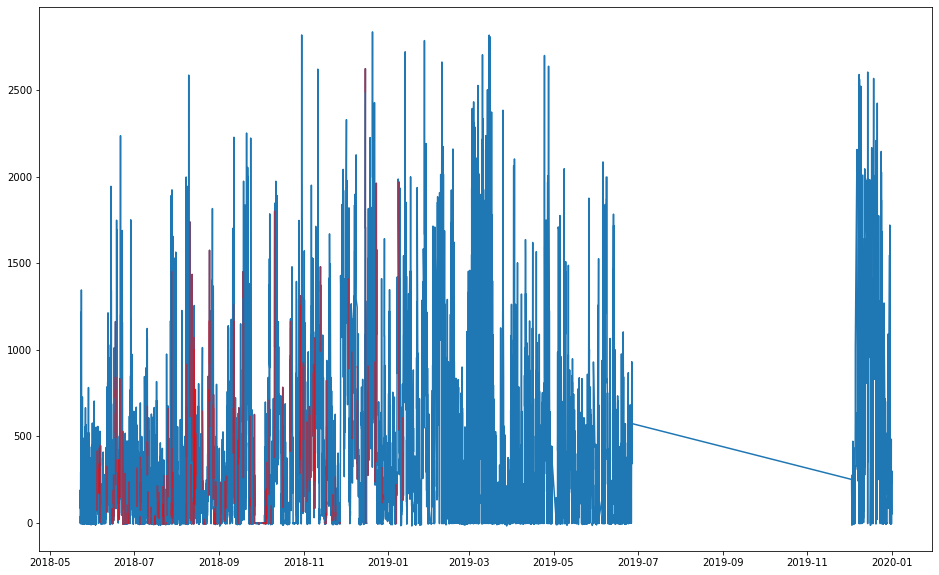

0.2597777843475342


In [9]:
w = 0.2 #10 days
query_set = []
start_t = time.time()
signal = series[0]
start = signal.index[0]
end = signal.index[-1]
fig = plt.figure(figsize=(16,10))
# Add a plot to the figure
ax = fig.add_subplot(111)
ax.plot(signal)
#to for thelei allagi logw derate
for ti in random.choices(groundtruth.index, k=100):
    #ti = ti.replace(hour=0, minute=0, second=0)
    a = bisect_left(signal.index, ti)
    b = bisect_left(signal.index, ti+pd.Timedelta(days = w))
    if a > 0:
        edge_a = signal.iloc[a-1:a+1]
        slope_a = (edge_a.values[1]-edge_a.values[0])/(edge_a.index[1].timestamp()-edge_a.index[0].timestamp())
        intercept_a = edge_a.values[0] - slope_a*edge_a.index[0].timestamp()
        y_a = slope_a*(ti).timestamp()+intercept_a 
        
    else:
        y_a = signal.values[a]
    if b < len(signal)-1:    
        edge_b = signal.iloc[b-1:b+1]
        slope_b = (edge_b.values[1]-edge_b.values[0])/(edge_b.index[1].timestamp()-edge_b.index[0].timestamp())
        intercept_b = edge_b.values[0] - slope_b*edge_b.index[0].timestamp()
        y_b = slope_b*(ti+pd.Timedelta(days = w)).timestamp()+intercept_b
    else:
        y_b = signal.values[-1]

    query = np.concatenate(([y_a], signal.iloc[a:b], [y_b]))
    
    index = np.concatenate((pd.DatetimeIndex([ti]), signal.index[a:b].to_numpy(), pd.DatetimeIndex([ti+pd.Timedelta(days = w)])))
    ax.plot(pd.Series(query, index = index),alpha =0.5,color ='red')
    query_set.append(query)
plt.show()

print(time.time()-start_t)    


In [10]:
int(np.floor(np.mean([len(q) for q in query_set])))

9

First attempt for preprocessing to verify that the parameters induce a good partitioning of the data.

In [11]:
answers = {}
times = {}
for i, signal in enumerate(series):
    R = 5000
    m = int(np.floor(np.mean([len(q) for q in query_set])))#50 #600*6*24
    N = 1
    olagiaola=dict()
    for W in range(100,200,100):
        start_t = time.time()
        ts = subann.TimeSeries([[x] for x in signal.values], [int(t.timestamp()-signal.index[0].timestamp()) for t in signal.index])
        DS = subann.SubAnnDS(ts, W, R, m, False)
        print(f'Preprocessing time: {time.time()-start_t}')
        print(DS.stats())

Preprocessing time: 0.12027573585510254
None
Number of keys stored: 29
Total number of subsequences stored: 16137
Average number of subsequences per key: 556.448
Maximum bucket size: 8304


In [12]:
signal

2018-05-22 23:10:00    110.940002
2018-05-23 01:00:00    152.759885
2018-05-23 01:10:00     87.970001
2018-05-23 01:50:00    155.555711
2018-05-23 02:00:00     85.379997
                          ...    
2019-12-31 21:30:00     48.653336
2019-12-31 21:40:00    173.619995
2019-12-31 23:00:00    298.524207
2019-12-31 23:10:00     -1.196000
2019-12-31 23:50:00     -1.196000
Length: 16137, dtype: float64

In [13]:
query_set[0]

array([  72.05835849,   72.05835849,   30.59000014,  118.80016823,
         45.56999968,  432.42642009,  200.66999817,  378.61570671,
       1449.4855957 , 1449.4855957 ])

In [14]:
m

9

Preprocessing and queries:

In [15]:
#exact
answs_ex = {}
#for j, query in tqdm(enumerate(query_set)):
m = 600*6*5
signal = series[0]
ts = subann.TimeSeries([[x] for x in signal.values], [int(t.timestamp()-signal.index[0].timestamp()) for t in signal.index])
#DS = subann.SubAnnDS(ts, 0.005, R, m, True) #does not apply WF filtering, checks all windows of length <=m
DS = subann.SubAnnDS(ts, 0, 200, m, False)  #does not apply WF filtering, checks all windows of length =m
start_e = time.time()        
for j, query in enumerate(query_set):
    #print(j)
    
    q = subann.TimeSeries([[x] for x in query])
    answs_ex[j] = [DS.exact_nn_query(q)]
end_e=time.time()-start_e

In [16]:
from tqdm import tqdm
answers = {}
times = {}
# R = 0.000001
# W = 50.001
R = 1
m = 600*6*5#5#*24
N = 1
olagiaola=dict()

for W in range(10,300,10):
    print(W)
    av_r=[]
    av_e=[]
    frac_av=[]
    ts = subann.TimeSeries([[x] for x in signal.values], [int(t.timestamp()-signal.index[0].timestamp()) for t in signal.index])
    #DS = subann.SubAnnDS(ts, 0.005, R, m, True) #does not apply WF filtering, checks all windows of length <=m
    DS = subann.SubAnnDS(ts, W, 200, m, False)  #does not apply WF filtering, checks all windows of length =m

    for i, signal in (enumerate(series)):
        q_answers = []
        frac = []
        times_r=[]
        times_e=[]
        n_ex = []
        n_apprx = []
        for j, query in tqdm(enumerate(query_set)):
            q = subann.TimeSeries([[x] for x in query])
            start_r = time.time()
            answs = [DS.ann_query(q)]
            answers[W,j] = answs             
            end_r=time.time()-start_r
            
            frac.append(len(set(answs).intersection(set(answs_ex[j]))))
            times_r.append(end_r)
            times_e.append(end_e)
            if len(answs) > 0: 
                q_answers.append(answs)
        frac_av.append(frac)
        print(np.mean(frac))
        av_r.append(np.mean(times_r))
        
           
        times[i] = time.time()-start_t
    olagiaola[W]=[frac_av,av_r]


10


100it [00:00, 426.57it/s]


0.07
20


100it [00:00, 296.18it/s]


0.09
30


100it [00:00, 330.13it/s]


0.08
40


100it [00:00, 419.36it/s]


0.06
50


100it [00:00, 247.03it/s]


0.11
60


100it [00:00, 104.19it/s]


0.07
70


100it [00:00, 197.14it/s]


0.16
80


100it [00:00, 255.25it/s]


0.13
90


100it [00:00, 221.03it/s]


0.14
100


100it [00:01, 84.35it/s]


0.16
110


100it [00:01, 63.59it/s]


0.24
120


100it [00:00, 131.60it/s]


0.16
130


100it [00:00, 228.06it/s]


0.15
140


100it [00:00, 191.11it/s]


0.13
150


100it [00:01, 78.51it/s]


0.19
160


100it [00:00, 161.86it/s]


0.17
170


100it [00:01, 88.26it/s]


0.19
180


100it [00:02, 38.20it/s]


0.23
190


100it [00:04, 24.29it/s]


0.32
200


100it [00:04, 22.77it/s]


0.35
210


100it [00:01, 85.48it/s]


0.19
220


100it [00:02, 34.34it/s]


0.32
230


100it [00:01, 62.19it/s]


0.3
240


100it [00:04, 22.60it/s]


0.35
250


100it [00:03, 30.47it/s]


0.35
260


100it [00:04, 23.36it/s]


0.32
270


100it [00:03, 26.22it/s]


0.33
280


100it [00:00, 101.35it/s]


0.23
290


100it [00:03, 27.80it/s]

0.38


In [17]:
mean_jacc = []
appr_times = []
ex_times = []
for key in olagiaola.keys():
    #print(f'{key}: {np.array(olagiaola[key][0])[np.array(olagiaola[key][0])!=-1]}')
    print(f'{key}: {np.mean(np.array(olagiaola[key][0])[np.array(olagiaola[key][0])!=-1])}')
    mean_jacc.append(np.mean(np.array(olagiaola[key][0])))
    print(f'time for approximate query {olagiaola[key][1][0]}')
    appr_times.append(olagiaola[key][1][0])                  
    

10: 0.07
time for approximate query 0.0023053860664367675
20: 0.09
time for approximate query 0.003358607292175293
30: 0.08
time for approximate query 0.0030132436752319334
40: 0.06
time for approximate query 0.002358701229095459
50: 0.11
time for approximate query 0.004022655487060547
60: 0.07
time for approximate query 0.009517364501953125
70: 0.16
time for approximate query 0.005032398700714111
80: 0.13
time for approximate query 0.0038976311683654786
90: 0.14
time for approximate query 0.004503035545349121
100: 0.16
time for approximate query 0.011806981563568115
110: 0.24
time for approximate query 0.01568703889846802
120: 0.16
time for approximate query 0.007566847801208496
130: 0.15
time for approximate query 0.004361400604248047
140: 0.13
time for approximate query 0.005174667835235596
150: 0.19
time for approximate query 0.012692255973815918
160: 0.17
time for approximate query 0.0061534690856933595
170: 0.19
time for approximate query 0.011244690418243409
180: 0.23
time for a

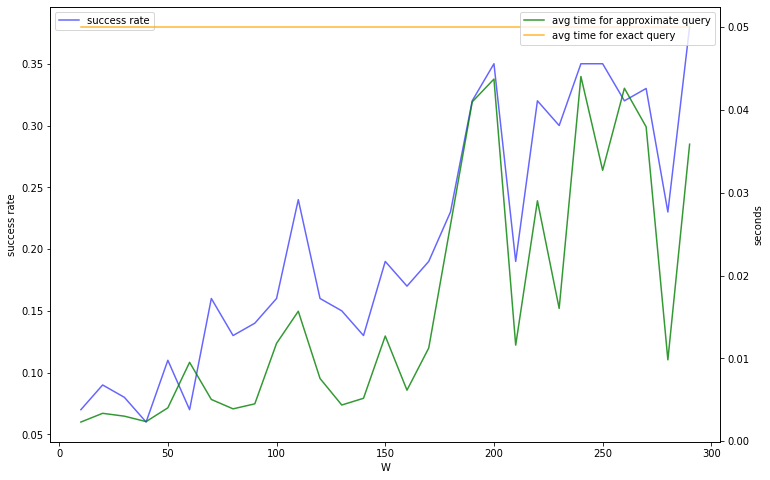

In [18]:
x_axis = range(10,300,10)
fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.plot(x_axis, mean_jacc, label = 'success rate',color = 'blue', alpha = 0.6)
ax1.set_ylabel('success rate')
ax1.set_xlabel('W')
#plt.legend()
ax1.legend()
ax2 = ax1.twinx()
ex_times = [end_e/100]*len(appr_times)
ax2.plot(x_axis, appr_times, color = 'green', alpha = 0.8, label = 'avg time for approximate query')
ax2.plot(x_axis, ex_times, color = 'orange', alpha = 0.8, label = 'avg time for exact query')
ax2.set_ylabel('seconds')
ax2.legend(loc = 1)
plt.show()